<a href="https://colab.research.google.com/github/evaneigomes/Kaplanmeier/blob/main/Kaplan_Meier_vfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Data_Breach_Chronology_Kaplameyer.xlsx to Data_Breach_Chronology_Kaplameyer (1).xlsx
📂 Dimensões do dataset (linhas, colunas): (72553, 3)

📌 Tipos de dados por coluna:
breach_date          object
organization_type    object
breach_type          object
dtype: object

🔎 Primeiras 5 linhas do dataset:
  breach_date organization_type breach_type
0  2020-09-05               BSR        HACK
1  2021-08-16              UNKN        UNKN
2  2021-03-15              UNKN        UNKN
3  2010-02-18               BSO        PORT
4  2020-09-10               MED        UNKN

❗ Valores ausentes por coluna:
breach_date          0
organization_type    0
breach_type          0
dtype: int64

📊 Estatísticas descritivas para colunas numéricas:
       breach_date organization_type breach_type
count        72553             72553       72553
unique        4716                 8           8
top           UNKN              UNKN        UNKN
freq         32411             22540       40038

📊 Contagem de reg

/tmp/ipython-input-4157330169.py:102: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  serie = df.resample('M').size().fillna(0)


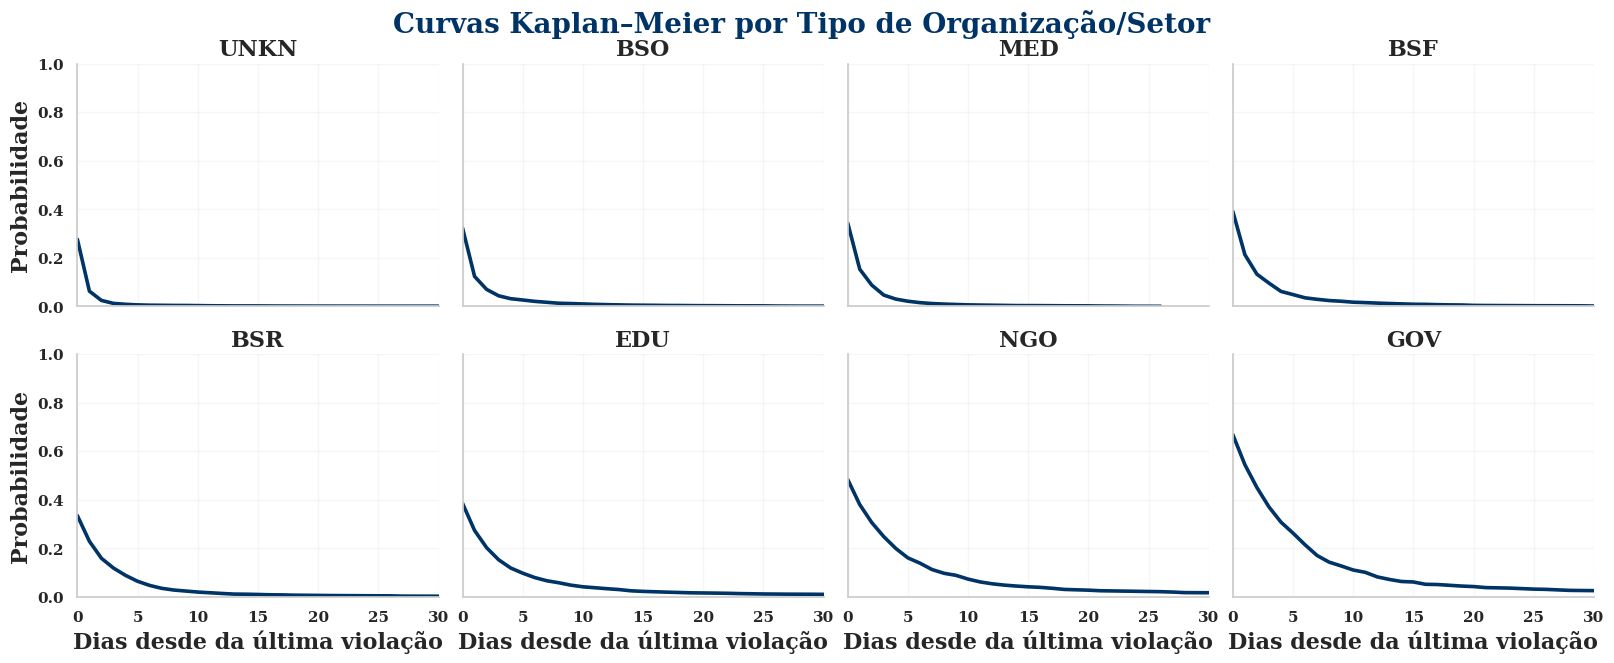

In [28]:
# ============================================
# 1. Importação de Bibliotecas
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ============================================
# 2. Upload e Carga do Dataset
# ============================================

# Faz upload do arquivo local para o Colab
uploaded = files.upload()

# Lê o arquivo Excel enviado
df_original = pd.read_excel(next(iter(uploaded)))

# Faz uma cópia do DataFrame original para evitar alterar os dados brutos
df = df_original.copy()

# ============================================
# 3. Visão Geral do Dataset
# ============================================

print("📂 Dimensões do dataset (linhas, colunas):", df.shape)
print("\n📌 Tipos de dados por coluna:")
print(df.dtypes)

print("\n🔎 Primeiras 5 linhas do dataset:")
print(df.head())

# Verifica valores ausentes
print("\n❗ Valores ausentes por coluna:")
print(df.isnull().sum())

# Estatísticas descritivas das colunas numéricas
print("\n📊 Estatísticas descritivas para colunas numéricas:")
print(df.describe())

# Contagem por tipo de organização
if 'organization_type' in df.columns:
    print("\n📊 Contagem de registros por tipo de organização:")
    print(df['organization_type'].value_counts())

# Contagem por tipo de violação
if 'breach_type' in df.columns:
    print("\n📊 Contagem de registros por tipo de violação:")
    print(df['breach_type'].value_counts())

# Salva as contagens em CSV
df['organization_type'].value_counts().to_csv("contagem_por_organization_type.csv")
df['breach_type'].value_counts().to_csv("contagem_por_breach_type.csv")

print("\n✅ Arquivos de contagem salvos:")
print("- contagem_por_organization_type.csv")
print("- contagem_por_breach_type.csv")

# ============================================
# 4. Pré-processamento de Datas
# ============================================

# Função para ajustar datas incompletas (ano ou ano-mês)
def ajustar_datas(data_str):
    """
    Converte valores de datas que podem estar incompletos:
      - 'YYYY' → 'YYYY-01-01'
      - 'YYYY-MM' → 'YYYY-MM-01'
      - 'YYYY-MM-DD' → mantém
      - Valores inválidos → NaT
    """
    try:
        if pd.isna(data_str):
            return pd.NaT
        data_str = str(data_str)
        if len(data_str) == 4:            # Apenas ano
            return pd.Timestamp(data_str + '-01-01')
        elif len(data_str) == 7:          # Ano e mês
            return pd.Timestamp(data_str + '-01')
        else:                             # Data completa
            return pd.Timestamp(data_str)
    except:
        return pd.NaT

# Aplica a função na coluna de datas
df['breach_date'] = df['breach_date'].apply(ajustar_datas)

# Converte a coluna para datetime de forma robusta
df['breach_date'] = pd.to_datetime(df['breach_date'], errors='coerce')

# Define a coluna de data como índice do DataFrame
df.set_index('breach_date', inplace=True)

# Filtra o período de interesse (2010 a 2023)
df = df[(df.index >= '2010-01-01') & (df.index < '2024-01-01')]

# ============================================
# 5. Série Temporal Mensal
# ============================================

# Conta incidentes por mês
serie = df.resample('M').size().fillna(0)

# ============================================
# 6. Instalação e Importação da Biblioteca de Sobrevivência
# ============================================
!pip install lifelines --quiet
from lifelines import KaplanMeierFitter

# ============================================
# Kaplan–Meier Facetado – Versão UnB
# ============================================

import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Paleta institucional UnB
cor_unb_azul = "#003366"
cor_unb_verde = "#00923F"
cor_grid = "#DDDDDD"

# Tema mais profissional
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "legend.fontsize": 16
})

incident_counts = df['organization_type'].value_counts()
orgs_to_keep = incident_counts[incident_counts >= 10].index.tolist()

facet_data = []

for org in orgs_to_keep:
    df_org = df[df['organization_type'] == org].sort_index()
    df_org['days_since_last'] = df_org.index.to_series().diff().dt.days
    df_org = df_org.dropna(subset=['days_since_last'])

    if len(df_org) < 2:
        continue

    kmf = KaplanMeierFitter()
    kmf.fit(df_org['days_since_last'], event_observed=[1] * len(df_org))

    km_df = kmf.survival_function_.reset_index()
    km_df.columns = ['days', 'survival']
    km_df['organization_type'] = org
    km_df['n'] = len(df_org)

    facet_data.append(km_df)

facet_df = pd.concat(facet_data, ignore_index=True)

# --------------------------------------------
# Painéis facetados (estilo científico UnB)
# --------------------------------------------
g = sns.FacetGrid(
    facet_df,
    col="organization_type",
    col_wrap=4,
    height=3.4,
    aspect=1.2,
    sharex=True,
    sharey=True
)

g.map_dataframe(
    sns.lineplot,
    x="days",
    y="survival",
    linewidth=2.6,
    color=cor_unb_azul    # Azul institucional
)

# Configurações
g.set_axis_labels("Dias desde da última violação", "Probabilidade")
g.set(xlim=(0, 30), ylim=(0, 1))
g.set_titles(col_template="{col_name}")

# Grid mais elegante
for ax in g.axes.flat:
    ax.grid(alpha=0.25, color=cor_grid)

# Título geral
plt.subplots_adjust(top=0.90)
g.fig.suptitle(
    "Curvas Kaplan–Meier por Tipo de Organização/Setor",
    fontsize=20,
    fontweight="bold",
    color=cor_unb_azul
)

plt.show()
